# IEEE IoT - Revision R1

In this revision, we apply our algorithm to a new dataset to further validate and enhance our approach.

## Dataset Overview

The dataset, titled "Degradation Measurement of Robot Arm Position Accuracy," is sourced from the National Institute of Standards and Technology (NIST). It includes:

- **Tool Center Position (TCP) Health Data:** High-level data on the robot's TCP.
- **Controller-Level Components Information:** Data on joint positions, velocities, currents, temperatures, and more.

For data collection, a trajectory was programmed for the Universal Robot (UR5), which approached and stopped at randomly selected locations in its workspace. The robot operated under varying conditions of temperature, payload, and speed. The TCP (x, y, z) positions were measured using a 7-D measurement system developed at NIST. Differences between the measured positions and the nominal positions (calculated by the robot's kinematic parameters) were recorded. Additionally, controller-level sensing data were collected from each joint to understand the influences of position degradation due to factors like temperature, payload, and speed. Control variables are detailed in the dataset's header file (UR5TestResult_header.xlsx). We make use the `joint_velocity` values of this dataset.

## How to Access the Dataset

You can download the dataset directly from the NIST repository using the following link:

[Download the Dataset from NIST](https://data.nist.gov/pdr/lps/754A77D9DA1E771AE0532457068179851962)

We have put those files to `dataset` folder. You can do the same to avoid path-related errors.

In [47]:
# We make use below libs.
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Preprocessing the dataset

In [7]:
# Read the CSV without using the first row as header (header=None)
df_all = pd.read_csv("dataset/ur5testresult_halfspeed_payload1.6lb_1.csv", header=None)

# The original dataset does not have header names, so I put instead
joint_vel_names = ['joint1_vel', 'joint2_vel', 'joint3_vel', 'joint4_vel', 'joint5_vel', 'joint6_vel']
df_joint_vel = df_all.iloc[:, 19:25].copy()
df_joint_vel.columns = joint_vel_names

print(df_joint_vel.head())

# Define the dataset folder path
dataset_folder = "dataset"

# List all files in the dataset folder
file_list = os.listdir(dataset_folder)

# Print the list of file names
print(file_list)

  joint1_vel  joint2_vel  joint3_vel  joint4_vel  joint5_vel joint6_vel
0       [0.0         0.0        -0.0         0.0         0.0       0.0]
1       [0.0         0.0        -0.0         0.0         0.0       0.0]
2       [0.0         0.0        -0.0         0.0         0.0       0.0]
3       [0.0         0.0        -0.0         0.0         0.0       0.0]
4       [0.0         0.0        -0.0         0.0         0.0       0.0]
['ur5testresult_fullspeed_payload4.5lb_2.csv', 'ur5testresult_halfspeed_payload1.6lb_3.csv', 'ur5testresult_halfspeed_payload1.6lb_1.csv', 'ConveyorXarmData', 'ur5testresult_halfspeed_payload4.5lb_2.csv', 'ur5testresult_halfspeed_payload4.5lb_1.csv', 'ur5testresult_fullspeed_payload4.5lb_3.csv', 'ur5testresult_halfspeed_payload4.5lb_3.csv', 'ur5testresult_fullspeed_payload4.5lb_1.csv', '.ipynb_checkpoints', 'ur5testresult_fullspeed_payload1.6lb_2.csv', 'ur5testresult_halfspeed_payload1.6lb_2.csv', 'ur5testresult_fullspeed_payload1.6lb_3.csv']


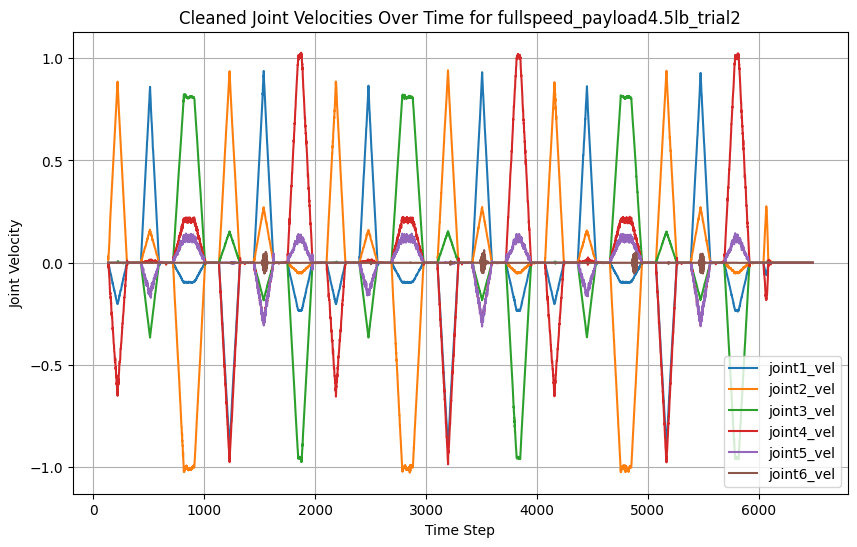

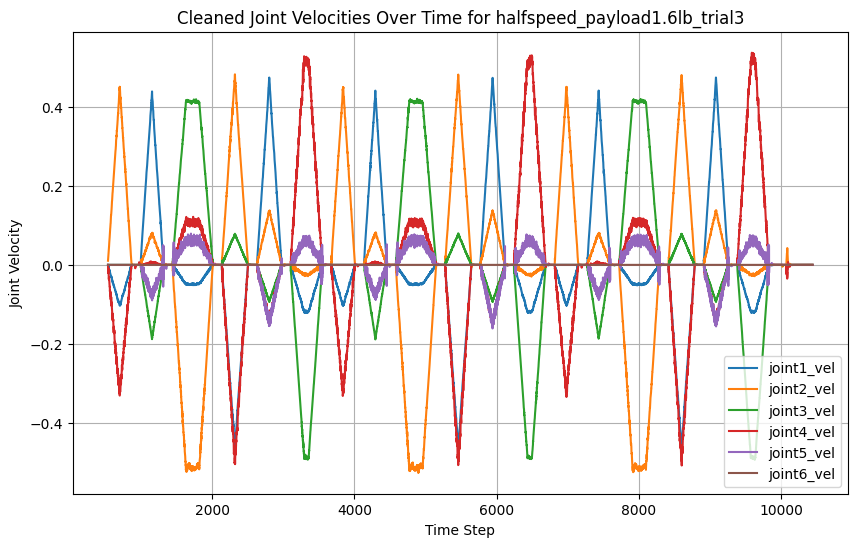

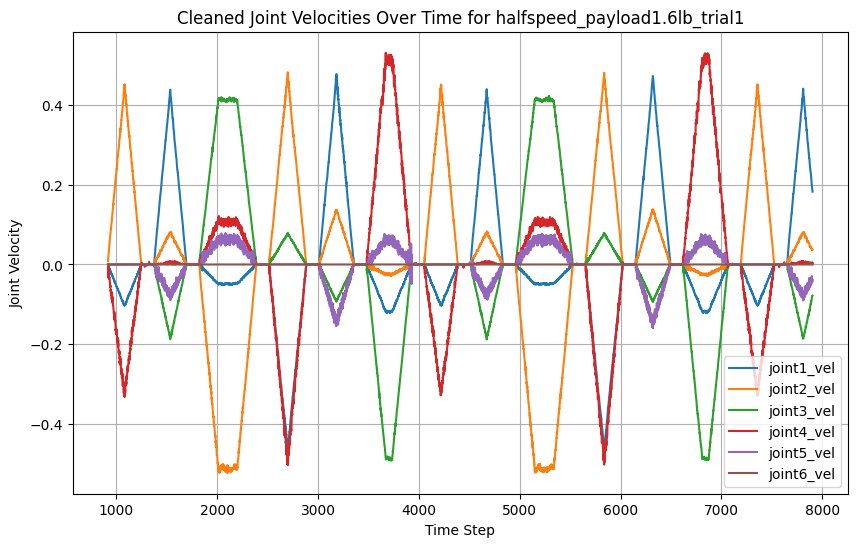

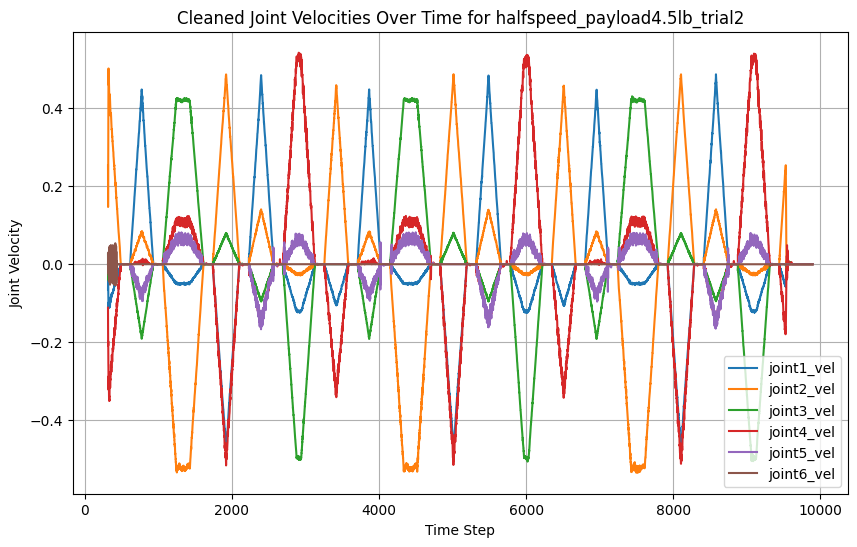

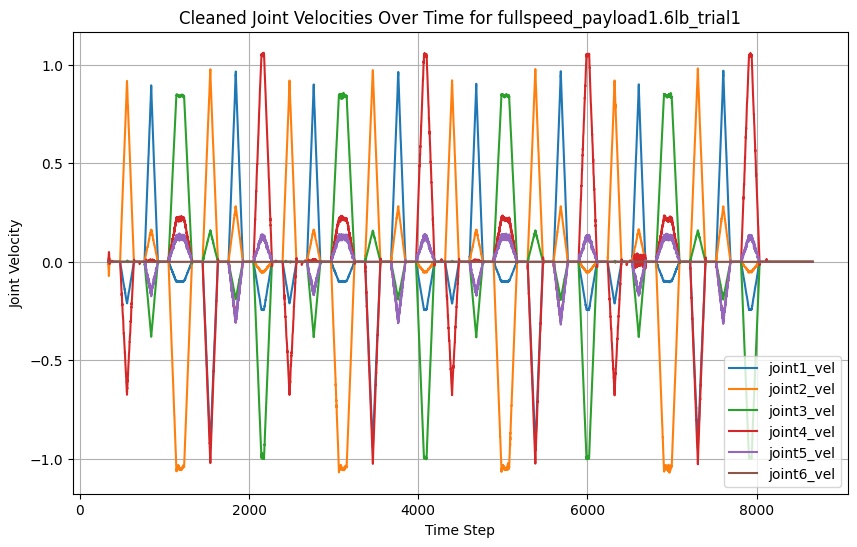

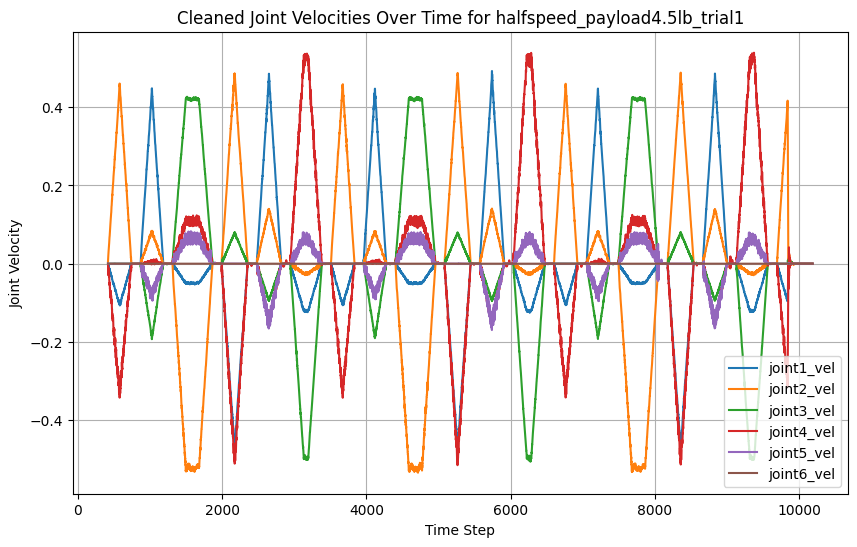

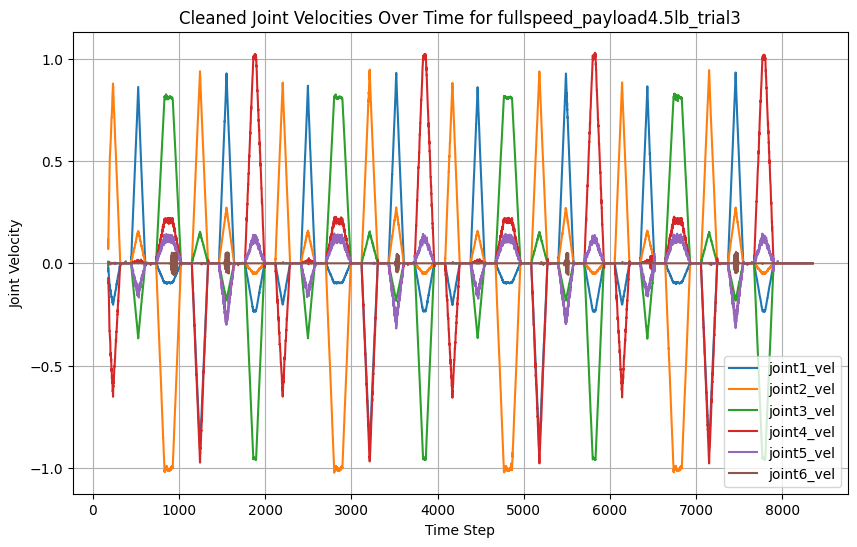

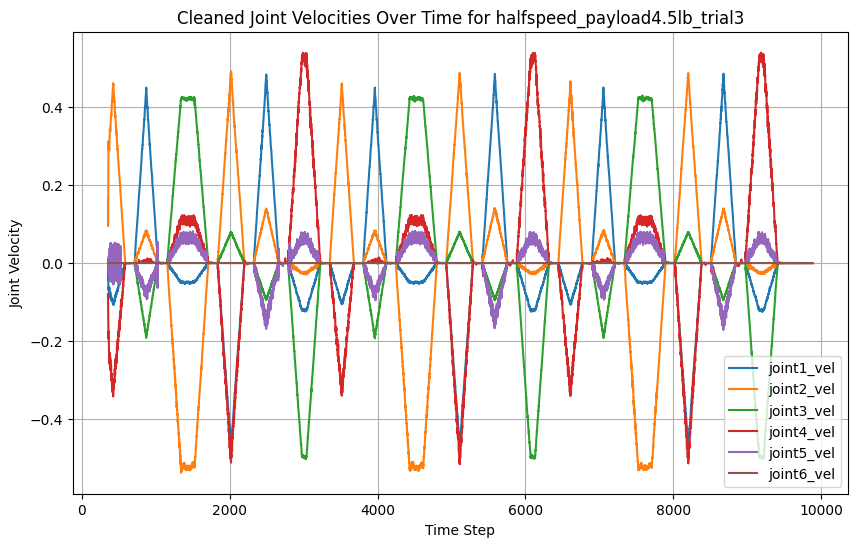

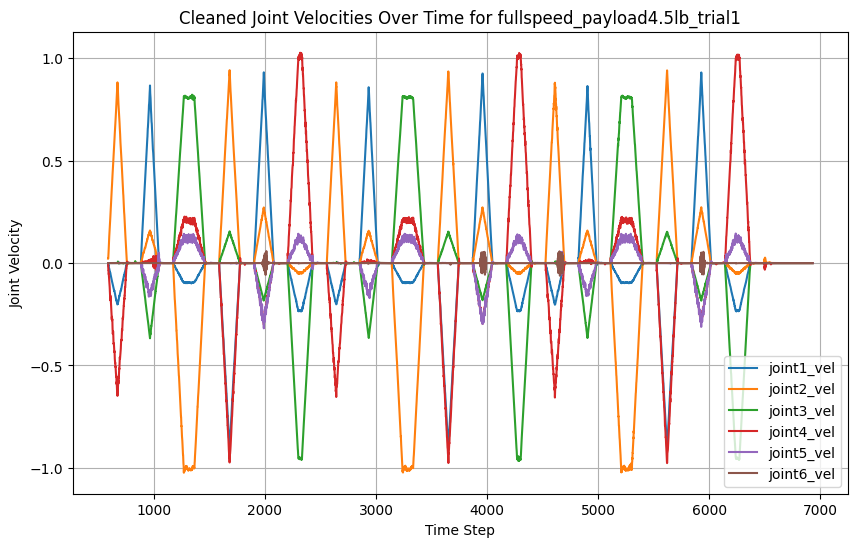

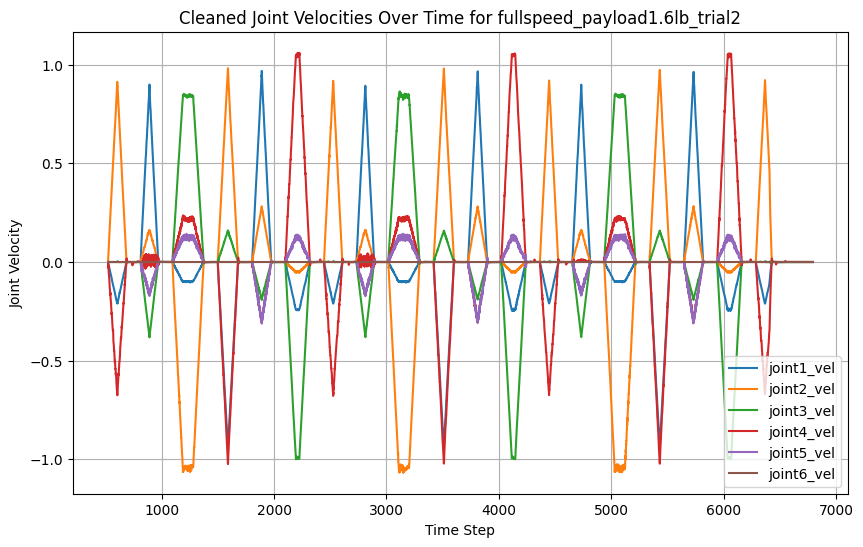

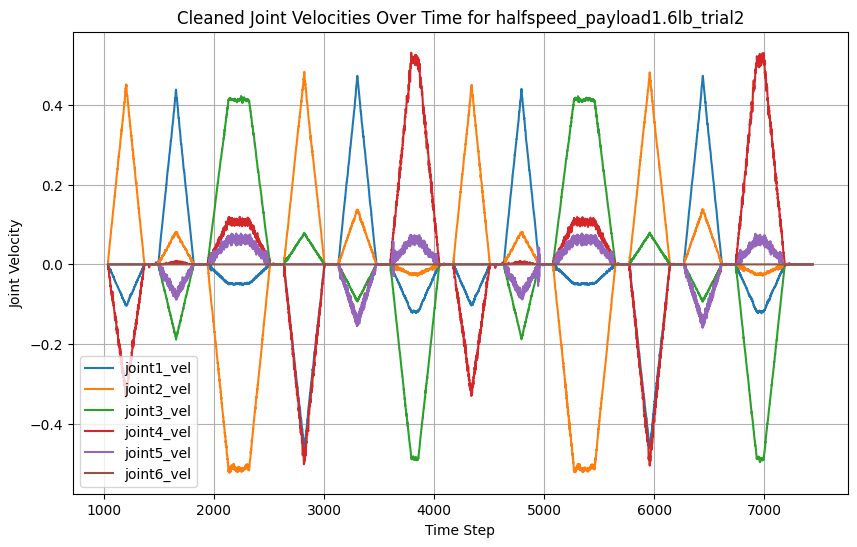

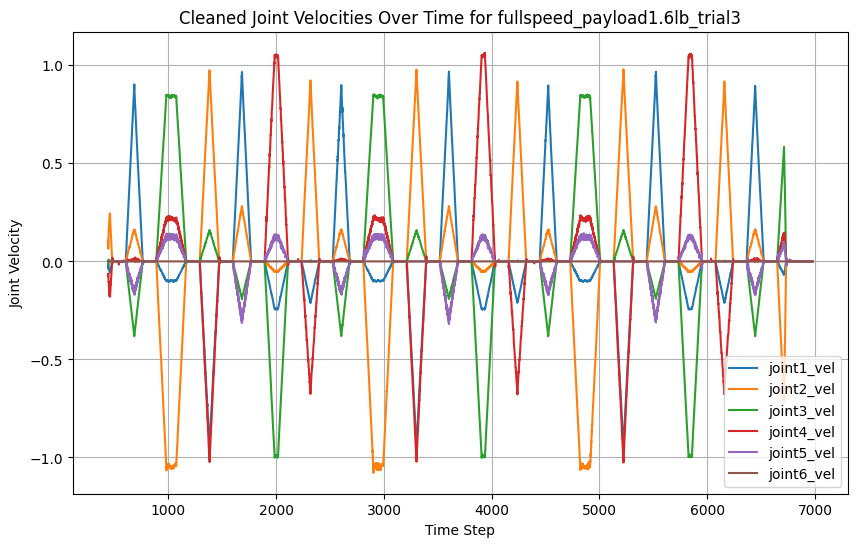


Data for fullspeed_payload4.5lb_trial2:
     joint1_vel  joint2_vel  joint3_vel  joint4_vel  joint5_vel  joint6_vel
134    0.000000    0.029350        -0.0    0.000000         0.0         0.0
135   -0.007887    0.012579        -0.0   -0.022866         0.0         0.0
136   -0.005152    0.023227        -0.0   -0.008197         0.0         0.0
137   -0.005113    0.027893        -0.0   -0.021524         0.0         0.0
138   -0.013486    0.036790        -0.0   -0.010258         0.0         0.0

Data for halfspeed_payload1.6lb_trial3:
     joint1_vel  joint2_vel  joint3_vel  joint4_vel  joint5_vel  joint6_vel
536         0.0    0.010469        -0.0    0.000000         0.0         0.0
537         0.0    0.012796        -0.0   -0.020086         0.0         0.0
538         0.0    0.011722        -0.0   -0.008077         0.0         0.0
539         0.0    0.019891        -0.0   -0.009803         0.0         0.0
540         0.0    0.021271        -0.0   -0.017209         0.0         0.0

Data 

In [13]:
# Define the dataset folder path
dataset_folder = "dataset"

# Get all CSV files following the naming convention (starting with "ur5testresult")
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith(".csv") and f.startswith("ur5testresult")]

# Define the joint velocity column names
joint_vel_names = ['joint1_vel', 'joint2_vel', 'joint3_vel', 'joint4_vel', 'joint5_vel', 'joint6_vel']

# Dictionary to store the processed DataFrames with descriptive keys
dfs = {}

# Regular expression to parse filename components: speed, payload, trial
pattern = re.compile(r'ur5testresult_(\w+)_payload([\d.]+lb)_(\d+)\.csv')

# Process each CSV file
for csv_file in csv_files:
    match = pattern.search(csv_file)
    if match:
        speed, payload, trial = match.groups()
        key = f"{speed}_payload{payload}_trial{trial}"
    else:
        # If the filename doesn't match, use the original filename as key
        key = csv_file
        print("Check file name!")
    
    file_path = os.path.join(dataset_folder, csv_file)
    # Read the CSV file without a header
    df_all = pd.read_csv(file_path, header=None)
    # Extract columns T to Y (indices 19 to 24)
    df_joint_vel = df_all.iloc[:, 19:25].copy()
    df_joint_vel.columns = joint_vel_names
    # Convert joint velocity values to numeric, removing brackets if present using Series.map
    for col in df_joint_vel.columns:
        df_joint_vel[col] = df_joint_vel[col].map(lambda x: float(str(x).replace('[', '').replace(']', '')))
    
    # Save the processed DataFrame using the descriptive key
    dfs[key] = df_joint_vel

# Function to remove consecutive initial idle rows (pre-movement)
def remove_initial_idle_points(df, threshold=1e-3):
    """
    Remove consecutive initial rows from df where all joint velocities are idle.
    'Idle' means that the maximum absolute joint velocity in the row is below 'threshold'.
    """
    for idx, row in df.iterrows():
        if row.abs().max() > threshold:
            # Once movement is detected, return the DataFrame from this row onward
            return df.loc[idx:]
    return df  # return original df if no movement is found

# Create a new dictionary for the cleaned DataFrames
dfs_cleaned = {key: remove_initial_idle_points(df) for key, df in dfs.items()}

# Plot the cleaned joint velocity data for each file
for key, df in dfs_cleaned.items():
    plt.figure(figsize=(10, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.xlabel("Time Step")
    plt.ylabel("Joint Velocity")
    plt.title(f"Cleaned Joint Velocities Over Time for {key}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the first few rows of each cleaned DataFrame
for key, df in dfs_cleaned.items():
    print(f"\nData for {key}:")

In [14]:
def create_sliding_windows(df, window_size=1000, step=1):
    """
    Splits the data into overlapping sliding windows.

    Parameters:
        df: pandas DataFrame containing time series data.
        window_size: number of samples per window.
        step: step size for the sliding window.

    Returns:
        List of DataFrame slices representing windows.
    """
    windows = []
    for start in range(0, len(df) - window_size + 1, step):
        windows.append(df.iloc[start:start + window_size])
    return windows

# Apply the sliding window function to all cleaned DataFrames
dfs_windows = {key: create_sliding_windows(df, window_size=1000, step=1) for key, df in dfs_cleaned.items()}

# Example: Print the number of windows generated for one of the datasets
for key, windows in dfs_windows.items():
    print(f"{key}: {len(windows)} windows created")

fullspeed_payload4.5lb_trial2: 5354 windows created
halfspeed_payload1.6lb_trial3: 8905 windows created
halfspeed_payload1.6lb_trial1: 5991 windows created
halfspeed_payload4.5lb_trial2: 8579 windows created
fullspeed_payload1.6lb_trial1: 7329 windows created
halfspeed_payload4.5lb_trial1: 8769 windows created
fullspeed_payload4.5lb_trial3: 7179 windows created
halfspeed_payload4.5lb_trial3: 8530 windows created
fullspeed_payload4.5lb_trial1: 5346 windows created
fullspeed_payload1.6lb_trial2: 5270 windows created
halfspeed_payload1.6lb_trial2: 5405 windows created
fullspeed_payload1.6lb_trial3: 5541 windows created


In [19]:
# Define categories based on speed and payload
categories = {
    "fullspeed_4.5lb": [],
    "halfspeed_4.5lb": [],
    "fullspeed_1.6lb": [],
    "halfspeed_1.6lb": []
}

# Assign windows to their respective categories
for key, windows in dfs_windows.items():
    if "fullspeed" in key and "4.5lb" in key:
        categories["fullspeed_4.5lb"].extend(windows)
    elif "halfspeed" in key and "4.5lb" in key:
        categories["halfspeed_4.5lb"].extend(windows)
    elif "fullspeed" in key and "1.6lb" in key:
        categories["fullspeed_1.6lb"].extend(windows)
    elif "halfspeed" in key and "1.6lb" in key:
        categories["halfspeed_1.6lb"].extend(windows)

# Function to split data into 60% train, 20% val, 20% test
def split_data(windows):
    train, temp = train_test_split(windows, test_size=0.4, shuffle=True, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42)
    return train, val, test

# Create train, validation, and test sets for each category
train_data = []
val_data = []
test_data = []
train_labels = []
val_labels = []
test_labels = []

# Assign integer labels to classes
label_mapping = {"fullspeed_4.5lb": 0, "halfspeed_4.5lb": 1, "fullspeed_1.6lb": 2, "halfspeed_1.6lb": 3}

for category, windows in categories.items():
    train, val, test = split_data(windows)

    train_data.extend(train)
    val_data.extend(val)
    test_data.extend(test)

    train_labels.extend([label_mapping[category]] * len(train))
    val_labels.extend([label_mapping[category]] * len(val))
    test_labels.extend([label_mapping[category]] * len(test))

# Convert to numpy arrays for deep learning compatibility
train_data = np.array([df.values for df in train_data])
val_data = np.array([df.values for df in val_data])
test_data = np.array([df.values for df in test_data])

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Print the final dataset sizes
print(f"Train: {train_data.shape}, Validation: {val_data.shape}, Test: {test_data.shape}")

# Count and print the distribution of labels in each dataset
print("\nClass distribution in training set:")
for label, count in Counter(train_labels).items():
    print(f"Class {label}: {count} samples")

print("\nClass distribution in validation set:")
for label, count in Counter(val_labels).items():
    print(f"Class {label}: {count} samples")

print("\nClass distribution in test set:")
for label, count in Counter(test_labels).items():
    print(f"Class {label}: {count} samples")

Train: (49317, 1000, 6), Validation: (16440, 1000, 6), Test: (16441, 1000, 6)

Class distribution in training set:
Class 0: 10727 samples
Class 1: 15526 samples
Class 2: 10884 samples
Class 3: 12180 samples

Class distribution in validation set:
Class 0: 3576 samples
Class 1: 5176 samples
Class 2: 3628 samples
Class 3: 4060 samples

Class distribution in test set:
Class 0: 3576 samples
Class 1: 5176 samples
Class 2: 3628 samples
Class 3: 4061 samples


In [21]:
# Compute mean and standard deviation from the training set only
train_mean = train_data.mean(axis=(0, 1), keepdims=True)
train_std = train_data.std(axis=(0, 1), keepdims=True)

# Normalize datasets using training statistics
train_data_norm = (train_data - train_mean) / train_std
val_data_norm = (val_data - train_mean) / train_std
test_data_norm = (test_data - train_mean) / train_std

# Print confirmation
print("Normalization completed.")
print(f"Train Mean: {train_mean.flatten()}")
print(f"Train Std: {train_std.flatten()}")

Normalization completed.
Train Mean: [-1.61824511e-03 -4.90911562e-03  3.61551802e-03  2.91998066e-04
  2.08130395e-05 -2.50184119e-06]
Train Std: [0.22230066 0.29311679 0.25739564 0.25040248 0.05835859 0.00269678]


### Training and Evaluation

In [22]:
# Define hyperparameters
NUM_FILTERS = 32
CONV_WIDTH = 3
MAX_POOL_SIZE = 2
NUM_CLASSES = 4  # since you have 4 classes

# Build the CNN model
cnn_model = tf.keras.Sequential([
    # Specify input shape: [time_steps, features]
    tf.keras.layers.Conv1D(NUM_FILTERS, 
                           kernel_size=CONV_WIDTH, 
                           activation='relu', 
                           input_shape=(train_data_norm.shape[1], train_data_norm.shape[2])),
    tf.keras.layers.Conv1D(NUM_FILTERS, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    # Final Dense layer for classification
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Print model summary to verify architecture
cnn_model.summary()

# Compile the model
cnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 32)           608       
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 498, 32)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 15936)             0         
                                                                 
 dense (Dense)               (None, 4)                 63748     
                                                                 
Total params: 67460 (263.52 KB)
Trainable params: 67460 (263.52 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

2025-03-10 22:36:18.317343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44902 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [23]:
# Train the model
history = cnn_model.fit(train_data_norm, train_labels, 
                        epochs=20, 
                        batch_size=64, 
                        validation_data=(val_data_norm, val_labels))

# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_data_norm, test_labels)
print("Test accuracy:", test_acc)

Epoch 1/20


2025-03-10 22:36:48.644629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-03-10 22:36:49.553364: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7ee448b070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-10 22:36:49.553392: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-03-10 22:36:49.572236: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741646209.715230  250784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


771/771 [==============================] - 12s 12ms/step - loss: 0.5804 - accuracy: 0.6677 - val_loss: 0.4323 - val_accuracy: 0.7720
Epoch 2/20
771/771 [==============================] - 6s 8ms/step - loss: 0.3676 - accuracy: 0.8089 - val_loss: 0.3181 - val_accuracy: 0.8446
Epoch 3/20
771/771 [==============================] - 6s 8ms/step - loss: 0.2506 - accuracy: 0.8885 - val_loss: 0.2495 - val_accuracy: 0.8792
Epoch 4/20
771/771 [==============================] - 6s 8ms/step - loss: 0.1159 - accuracy: 0.9641 - val_loss: 0.0682 - val_accuracy: 0.9846
Epoch 5/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0418 - accuracy: 0.9925 - val_loss: 0.0348 - val_accuracy: 0.9940
Epoch 6/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0207 - accuracy: 0.9961 - val_loss: 0.0082 - val_accuracy: 0.9999
Epoch 7/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9999
Epoch 8/20
771/

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 998, 32)           608       
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 498, 32)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15936)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 63748     
                                                                 
Total params: 67460 (263.52 KB)
Trainable params: 67460 (263.52 KB)
Non-trainable params: 0 (0.00 Byte)
________________

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


771/771 [==============================] - 6s 8ms/step - loss: 0.3428 - accuracy: 0.8252 - val_loss: 0.3208 - val_accuracy: 0.8276
Epoch 3/20
771/771 [==============================] - 6s 8ms/step - loss: 0.2300 - accuracy: 0.9047 - val_loss: 0.1534 - val_accuracy: 0.9730
Epoch 4/20
771/771 [==============================] - 6s 8ms/step - loss: 0.1216 - accuracy: 0.9639 - val_loss: 0.1016 - val_accuracy: 0.9785
Epoch 5/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0555 - accuracy: 0.9885 - val_loss: 0.0429 - val_accuracy: 0.9884
Epoch 6/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0365 - accuracy: 0.9912 - val_loss: 0.0228 - val_accuracy: 0.9991
Epoch 7/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0246 - accuracy: 0.9939 - val_loss: 0.0497 - val_accuracy: 0.9749
Epoch 8/20
771/771 [==============================] - 6s 8ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0123 - val_accuracy: 0.9997
Epoch 9/20
771/77

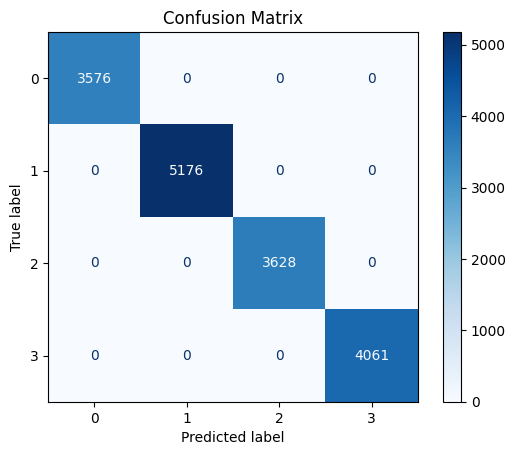

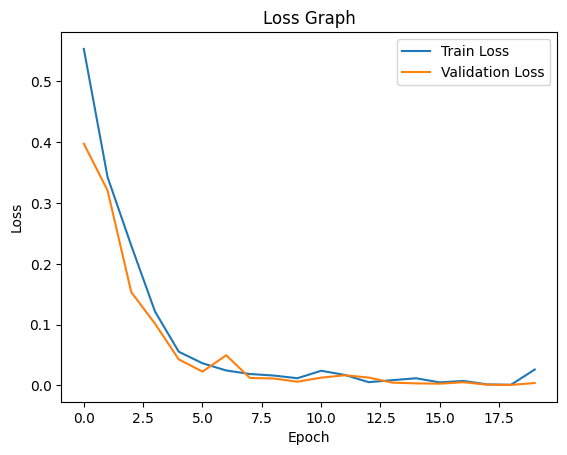

Results saved to training_results.json


In [25]:
# ---------------------------
# Hyperparameters and Setup
# ---------------------------
NUM_FILTERS = 32
CONV_WIDTH = 3
MAX_POOL_SIZE = 2
NUM_CLASSES = 4  # 4 classes for your labels
EPOCHS = 20
BATCH_SIZE = 64

# ---------------------------
# Build the CNN model
# ---------------------------
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, kernel_size=CONV_WIDTH, activation='relu',
                           input_shape=(train_data_norm.shape[1], train_data_norm.shape[2])),
    tf.keras.layers.Conv1D(NUM_FILTERS, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# ---------------------------
# Callback for saving the best model
# ---------------------------
checkpoint_path = "best_model.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model
    monitor='val_loss',       # Monitor validation loss
    mode='min',               # Lower validation loss is better
    save_best_only=True       # Only save the best model
)

# ---------------------------
# Train the model
# ---------------------------
history = cnn_model.fit(train_data_norm, train_labels,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(val_data_norm, val_labels),
                        callbacks=[model_checkpoint_callback])

# ---------------------------
# Load the best performing model from the saved file
# ---------------------------
best_model = tf.keras.models.load_model(checkpoint_path)

# ---------------------------
# Evaluate the best model
# ---------------------------
test_loss, test_acc = best_model.evaluate(test_data_norm, test_labels)
print("Test accuracy:", test_acc)

# ---------------------------
# Generate Predictions for Confusion Matrix
# ---------------------------
predictions = best_model.predict(test_data_norm)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Plot and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(NUM_CLASSES)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ---------------------------
# Plot the Loss Graph
# ---------------------------
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# ---------------------------
# Save Key Parameters and Training History to JSON
# ---------------------------
results = {
    'hyperparameters': {
         'NUM_FILTERS': NUM_FILTERS,
         'CONV_WIDTH': CONV_WIDTH,
         'MAX_POOL_SIZE': MAX_POOL_SIZE,
         'NUM_CLASSES': NUM_CLASSES,
         'EPOCHS': EPOCHS,
         'BATCH_SIZE': BATCH_SIZE
    },
    'history': history.history,  # Contains keys such as 'loss', 'val_loss', 'accuracy', 'val_accuracy'
    'test_loss': test_loss,
    'test_accuracy': test_acc
}

with open('training_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Results saved to training_results.json")

### Plotting in better way to be used in paper.

514/514 [==============================] - 2s 3ms/step


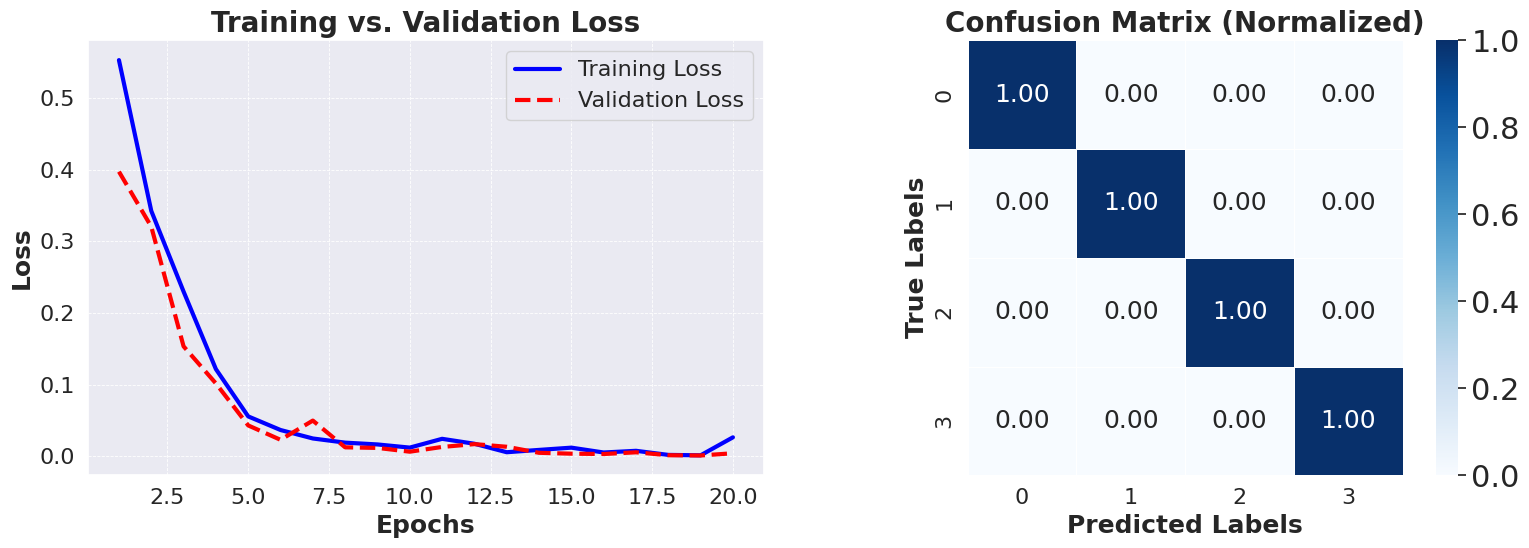

Combined side-by-side plots saved as 'combined_side_by_side.pdf'.


In [44]:
# ---------------------------
# Load Data and Model
# ---------------------------
# Load training results
with open('training_results.json', 'r') as f:
    results = json.load(f)
train_loss = results['history']['loss']
val_loss = results['history']['val_loss']
epochs = range(1, len(train_loss) + 1)

# Load best model and test data (ensure test_data_norm and test_labels are defined)
best_model = tf.keras.models.load_model('best_model.h5')
predictions = best_model.predict(test_data_norm)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ---------------------------
# Create Combined Figure with 2 Subplots Side by Side
# ---------------------------
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Wider figure for side-by-side plots

# Plot Loss Graph on the left subplot (ax1)
ax1.plot(epochs, train_loss, label='Training Loss', linewidth=3, color='blue')
ax1.plot(epochs, val_loss, label='Validation Loss', linewidth=3, linestyle='dashed', color='red')
ax1.set_xlabel('Epochs', fontsize=18, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=18, fontweight='bold')
ax1.set_title('Training vs. Validation Loss', fontsize=20, fontweight='bold')
ax1.tick_params(axis='both', labelsize=16)
ax1.legend(fontsize=16, loc='upper right')
ax1.grid(True, linestyle='--', linewidth=0.6)

# Plot Confusion Matrix on the right subplot (ax2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, square=True,
            ax=ax2, annot_kws={"size": 18})
ax2.set_xlabel('Predicted Labels', fontsize=18, fontweight='bold')
ax2.set_ylabel('True Labels', fontsize=18, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=20, fontweight='bold')
ax2.tick_params(axis='both', labelsize=16)

# Adjust layout to ensure everything fits well
fig.tight_layout()

# Save the combined figure as a single PDF file
plt.savefig('combined_side_by_side.pdf', bbox_inches='tight', dpi=300)
plt.show()

print("Combined side-by-side plots saved as 'combined_side_by_side.pdf'.")

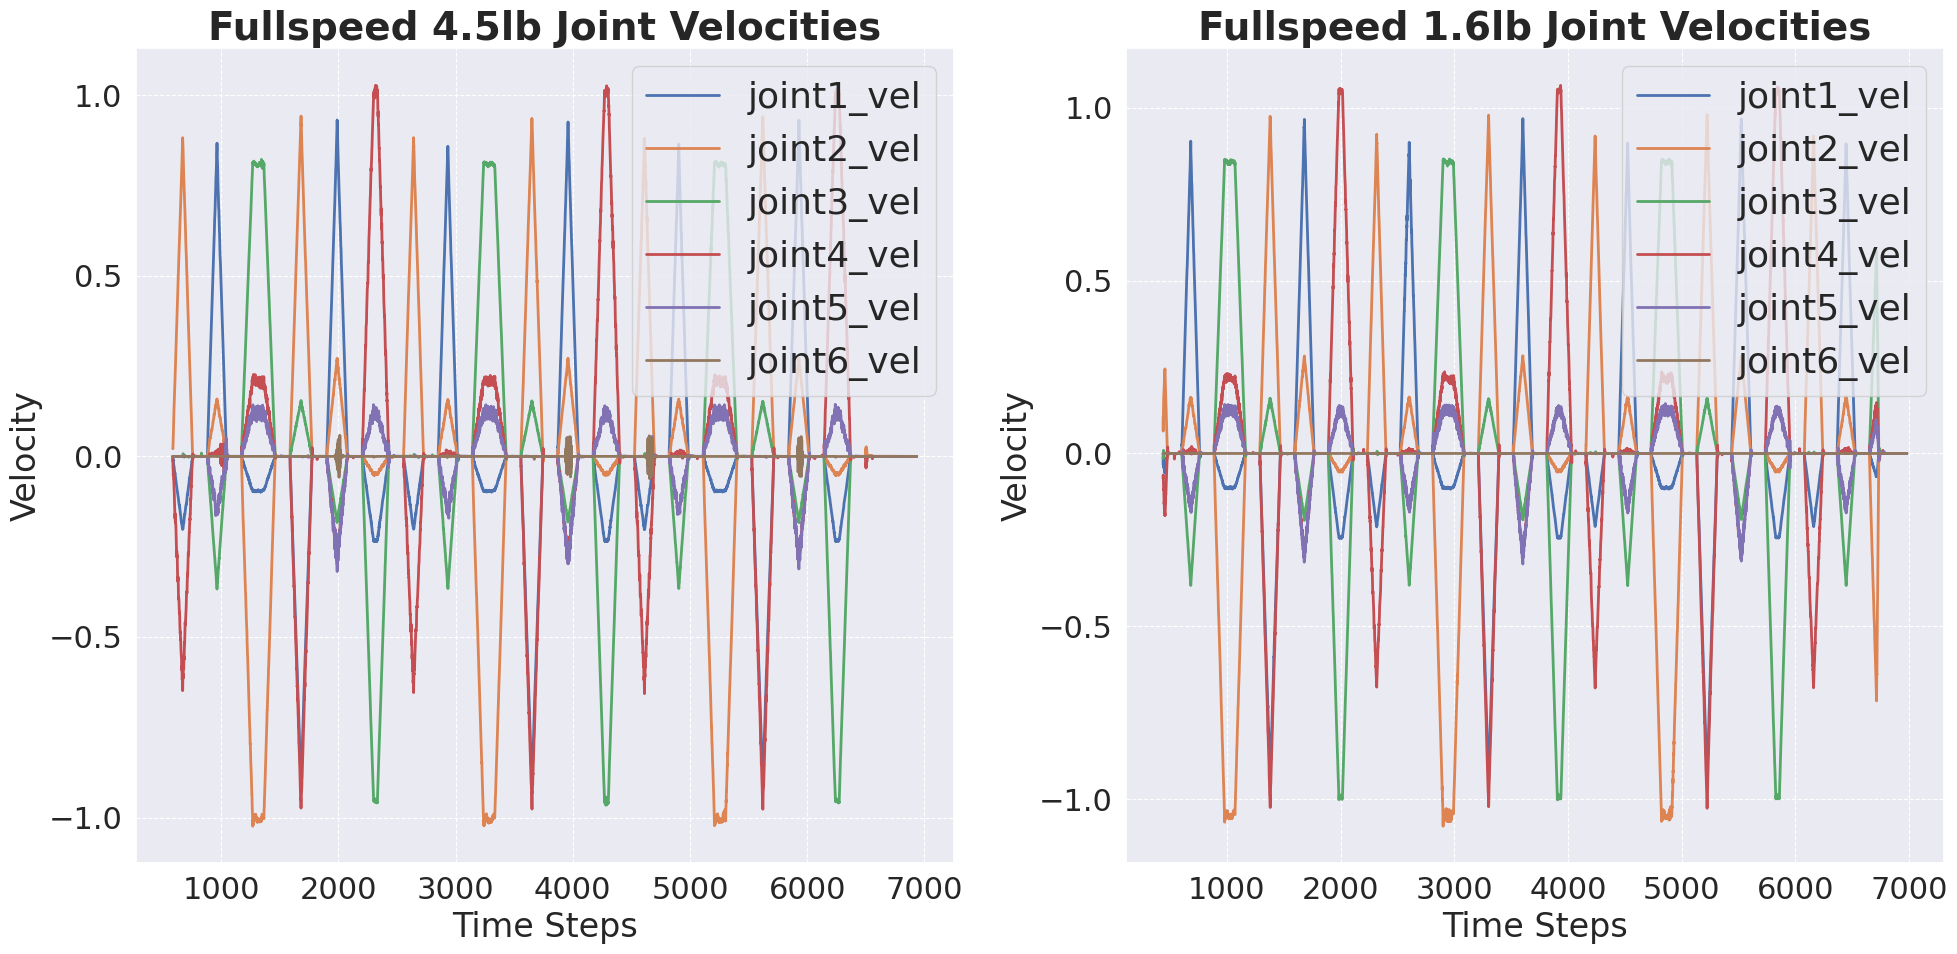

Joint velocities comparison plot saved as 'joint_velocities_comparison.pdf'.


In [40]:
# ---------------------------
# Global Plot Settings for Increased Font Sizes
# ---------------------------
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'legend.fontsize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

# ---------------------------
# Select Datasets for Plotting
# ---------------------------
# Extract the relevant datasets
fs45_key = None
fs16_key = None

# Find the correct dataset keys
for key in dfs_cleaned.keys():
    if "fullspeed" in key and "4.5lb" in key:
        fs45_key = key
    elif "fullspeed" in key and "1.6lb" in key:
        fs16_key = key

# Ensure the datasets were found
if fs45_key is None or fs16_key is None:
    raise ValueError("Could not find datasets for 'fullspeed_4.5lb' or 'fullspeed_1.6lb'.")

# Load the corresponding dataframes
df_fs45 = dfs_cleaned[fs45_key]
df_fs16 = dfs_cleaned[fs16_key]

# ---------------------------
# Create a Single Figure with Two Plots
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for fullspeed_4.5lb
for col in df_fs45.columns:
    axes[0].plot(df_fs45.index, df_fs45[col], label=col, linewidth=2)
axes[0].set_title('Fullspeed 4.5lb Joint Velocities', fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Velocity')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', linewidth=0.8)

# Plot for fullspeed_1.6lb
for col in df_fs16.columns:
    axes[1].plot(df_fs16.index, df_fs16[col], label=col, linewidth=2)
axes[1].set_title('Fullspeed 1.6lb Joint Velocities', fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Velocity')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', linewidth=0.8)

# ---------------------------
# Save and Show the Plot
# ---------------------------
plt.tight_layout()
plt.savefig("joint_velocities_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()

print("Joint velocities comparison plot saved as 'joint_velocities_comparison.pdf'.")